In [1]:
# Import packages
import numpy as np
import pandas as pd
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date, time, timedelta, timezone
import dateutil.parser as parser


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.2f' % x) # change decimal places



#### Loading the data and bringing it into shape

##### Sugarbeet field data

In [2]:
# load the data from the CSV file provided by the company
df_sugarbeet = pd.read_csv('/Users/clara/Neue_Fische/capstone_project/Shareholder/data/DatenfürGina_recorded2.csv', decimal=',', delimiter=';')

In [3]:
#check the dataframe
df_sugarbeet.head(2)

,CropID,BM,Betaine_NIR,BreedId,CRY_NIR,CSY_NIR,DM_NIR,FieldBlock,FieldId,Region,...,GinaSeednames!,SeriesId,SpectraName,StandardInd,TotalN_NIR,Trial,X,Y,Year,Anzahl
0,SB,B4,0.16,ACA,54.60,8.84,21.54,1,Emmeloord1,Niederlande,...,85,1501,B4_2021_40101001_Emme.spc,NaN,0.13,40101,2,1,2021,90
1,SB,B4,0.15,ACA,51.07,8.49,21.86,1,Emmeloord1,Niederlande,...,1204,1501,B4_2021_40101007_Emme.spc,Y,0.14,40101,2,2,2021,90


In [4]:
# change the remaining column names to lowercase for easier use later on
df_sugarbeet.columns = df_sugarbeet.columns.str.lower()

# rename some of the columns
df_sugarbeet.rename(columns={'ginams!': 'ms_comp', 'ginaotype!': 'otype_comp', 'ginapoll!': 'pollinator_comp', 'ginaseednames!': 'seednames_coded'}, inplace=True)

#remove the numbers from the fieldid
df_sugarbeet['fieldid'] = df_sugarbeet['fieldid'].replace(r'1', r'', regex=True)
df_sugarbeet['fieldid'] = df_sugarbeet['fieldid'].replace(r'_2', r'', regex=True)
df_sugarbeet['fieldid'] = df_sugarbeet['fieldid'].replace(r'2', r'', regex=True)
#drop the columns with unnecessary information after discussion with the stakeholder
df_sugarbeet.drop(['cropid','bm', 'breedid', 'locationid', 'fieldblock', 'fieldsubblock', 'filler',
       'labnr', 'layoutnr','plotid', 'plotindex', 'rep','spectraname', 'trial', 'year', 'anzahl', 'standardind'], axis=1, inplace=True)
#remove one outlier with negative value
df_sugarbeet = df_sugarbeet[df_sugarbeet.betaine_nir >= 0]
#exclude missing value (0.19 %)
df_sugarbeet = df_sugarbeet.dropna()

In [5]:
#Create station_location column
df_sugarbeet['station_location'] = df_sugarbeet['fieldid']
#replace stations locations to use the correct weatherinformation, based on discussion with stakeholder
df_sugarbeet['station_location'] = df_sugarbeet['station_location'].replace(r'Hamm', r'Soest', regex=True)
df_sugarbeet['station_location'] = df_sugarbeet['station_location'].replace(r'Oberviehhausen', r'Mattenkofen', regex=True)
df_sugarbeet['station_location'] = df_sugarbeet['station_location'].replace(r'Vierhöfen', r'Mattenkofen', regex=True)

In [6]:
# check the dataframe
print(f'the Sugarbeet dataframe has {df_sugarbeet.shape[0]} rows and {df_sugarbeet.shape[1]} columns.')
df_sugarbeet.head(2)

the Sugarbeet dataframe has 16477 rows and 19 columns.


,betaine_nir,cry_nir,csy_nir,dm_nir,fieldid,region,invert_nir,mark_nir,ms_comp,obj,otype_comp,pollinator_comp,sc_nir,seednames_coded,seriesid,totaln_nir,x,y,station_location
0,0.16,54.60,8.84,21.54,Emmeloord,Niederlande,0.18,5.36,2,23,2,308,16.19,85,1501,0.13,2,1,Emmeloord
1,0.15,51.07,8.49,21.86,Emmeloord,Niederlande,0.15,5.22,6,3,7,1191,16.63,1204,1501,0.14,2,2,Emmeloord


##### Weather field data

In [7]:
# import weather data, rename the columns in english and at the same time rename Unnamed1 to country and location to station-location
weather_column_names = (['station_location', 'country', 'Date_time', 'Day', 'Month', 'Year', 'Hour', 'air_temperature_avg', 'air_temperature_max', 'air_temperature_min',
                        'dew_point_avg', 'dew_point_min', 'solar_radiation', 'saturation_VPD_avg', 'saturation_VPD_min', 'relative_humidity_avg',
                        'relative_humidity_max', 'relative_humidity_min', 'precipitation', 'leaf_wetness', 'wind_speed_avg', 'wind_speed_max', 'wind_speed_gusts',
                        'wind_direction', 'EAG_soil_moisture_1', 'EAG_soil_moisture_2', 'EAG_soil_moisture_3', 'EAG_soil_moisture_4', 'EAG_soil_moisture_5', 'EAG_soil_moisture_6',
                        'soil_salinity_1', 'soil_salinity_2', 'soil_salinity_3', 'soil_salinity_4', 'soil_salinity_5', 'soil_salinity_6', 'soil_temperature_1_vg', 'soil_temperature_1_max',
                        'soil_temperature_1_min', 'soil_temperature_2_vg', 'soil_temperature_2_max', 'soil_temperature_2_min', 'soil_temperature_3_vg', 'soil_temperature_3_max',
                        'soil_temperature_3_min', 'soil_temperature_4_vg', 'soil_temperature_4_max', 'soil_temperature_4_min', 'soil_temperature_5_vg', 'soil_temperature_5_max',
                        'soil_temperature_5_min', 'soil_temperature_6_vg', 'soil_temperature_6_max', 'soil_temperature_6_min', 'solar_panel', 'battery',
                        'deltaT_avg', 'deltaT_max', 'deltaT_min', 'ET0'])
# import csv file
df_weatherstations = pd.read_csv('/Users/clara/Neue_Fische/capstone_project/Shareholder/data/wetterdaten_all-stations_hourly.csv', delimiter=';', decimal=',', header=0, names=weather_column_names)
#lower case the name of the columns, rename a col
df_weatherstations.columns = df_weatherstations.columns.str.lower()

In [8]:
#change date to datetime format and extract month and day, directly changing the month and day columns
df_weatherstations['date_time'] = pd.to_datetime(df_weatherstations['date_time'], yearfirst=True, format="%Y-%m-%d %H:%M:%S")
df_weatherstations['month'] = df_weatherstations['date_time'].dt.month
df_weatherstations['day'] = df_weatherstations['date_time'].dt.day


##### Location data and sowing/harvesting dates

In [9]:
# load data from CSV file
df_locations = pd.read_csv('/Users/clara/Neue_Fische/capstone_project/Shareholder/data/fieldid_gps_dates.csv')
# check df
df_locations.head(2)

,fieldid,latitude,longitude,sowing_year,sowing_month,sowing_day,harvesting_year,harvesting_month,havesting_day
0,Herchsheim,49.638659°,9.926104°,2021,4,11,2021,10,13
1,Herchsheim_2,49.636416°,9.942339°,2021,4,9,2021,9,26


In [10]:
# remove ° from lat and lon information
df_locations['latitude'] = df_locations['latitude'].replace(r'°', r'', regex=True)
df_locations['longitude'] = df_locations['longitude'].replace(r'°', r'', regex=True)
# in order to use the information in the lat and lon columns, first change the type to string, then to float
df_locations['latitude'] = df_locations['latitude'].astype(str)
df_locations['longitude'] = df_locations['longitude'].astype(str)
# float
df_locations['latitude'] = df_locations['latitude'].astype(float)
df_locations['longitude'] = df_locations['longitude'].astype(float)

##### open weather data

In [11]:
# load individual openweatherdata
df_anklam = pd.read_csv("data/Anklam.csv", delimiter=",")
df_bautzen = pd.read_csv("data/Bautzen.csv", delimiter=",")
df_emmeloord = pd.read_csv("data/Emmeloord.csv", delimiter=",")
df_goderville = pd.read_csv("data/Goderville.csv", delimiter=",")
df_hamm = pd.read_csv("data/Hamm.csv", delimiter=",")
df_herchsheim = pd.read_csv("data/Herchsheim.csv", delimiter=",")
df_lamotte = pd.read_csv("data/Lamotte.csv", delimiter=",")
df_lelystad = pd.read_csv("data/Lelystad.csv", delimiter=",")
df_mattenkofen = pd.read_csv("data/Mattenkofen.csv", delimiter=",")
df_oberviehhausen = pd.read_csv("data/Oberviehhausen.csv", delimiter=",")
df_pithiviers = pd.read_csv("data/Pithiviers.csv", delimiter=",")
df_soest = pd.read_csv("data/Soest.csv", delimiter=",")
df_sommepy1 = pd.read_csv("data/Sommepy1.csv", delimiter=",")
df_sommepy2 = pd.read_csv("data/Sommepy2.csv", delimiter=",")
df_stadthagen = pd.read_csv("data/Stadthagen.csv", delimiter=",")
df_vierhoefen = pd.read_csv("data/Vierhöfen.csv", delimiter=",")

# combine into one dataframe
df = pd.concat ([df_anklam,
            df_bautzen, 
            df_emmeloord, 
            df_goderville, 
            df_hamm, 
            df_herchsheim, 
            df_lamotte, 
            df_lelystad, 
            df_mattenkofen, 
            df_oberviehhausen, 
            df_pithiviers, 
            df_soest, 
            df_sommepy1, 
            df_sommepy2, 
            df_stadthagen,
            df_vierhoefen], ignore_index=True)

In [12]:
df.head(2)

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1262304000,2010-01-01 00:00:00 +0000 UTC,3600,Anklam,53.94,13.60,-0.89,NaN,-3.12,-4.97,...,NaN,NaN,NaN,NaN,NaN,98,804,Clouds,overcast clouds,04n
1,1262307600,2010-01-01 01:00:00 +0000 UTC,3600,Anklam,53.94,13.60,-0.81,NaN,-3.04,-4.96,...,NaN,NaN,NaN,NaN,NaN,98,804,Clouds,overcast clouds,04n


In [13]:
# split iso datetime according to the + and only keep the first (the date) in a new columns
df['date'] = df.dt_iso.apply(lambda x: x.split('+')[0])

# change the new column to datetime format
df['date'] = pd.to_datetime(df['date'])

# create additional columns for year, month, and day in addition to a plottingdate counting the day of the year
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['plotting_date'] = df['date'].dt.dayofyear

In [14]:
# drop unnecessary columns
df.drop(['visibility','sea_level', 'grnd_level', 'wind_gust', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h'], axis=1, inplace=True)


In [15]:
# create a dataframe for the year 2021 to match the sugarbeet data timeframe
df_2021 = df.query('year == 2021')

##### save changes in dataframes to a pickle

In [16]:
df_sugarbeet.to_pickle('pickles/01_df_sugarbeet.pkl')
df_weatherstations.to_pickle('pickles/01_df_weatherstations.pkl')
df_locations.to_pickle('pickles/01_df_locations.pkl')
df.to_pickle('pickles/01_df_openweather_2021.pkl')

### EDA

#### missing values

<AxesSubplot:>

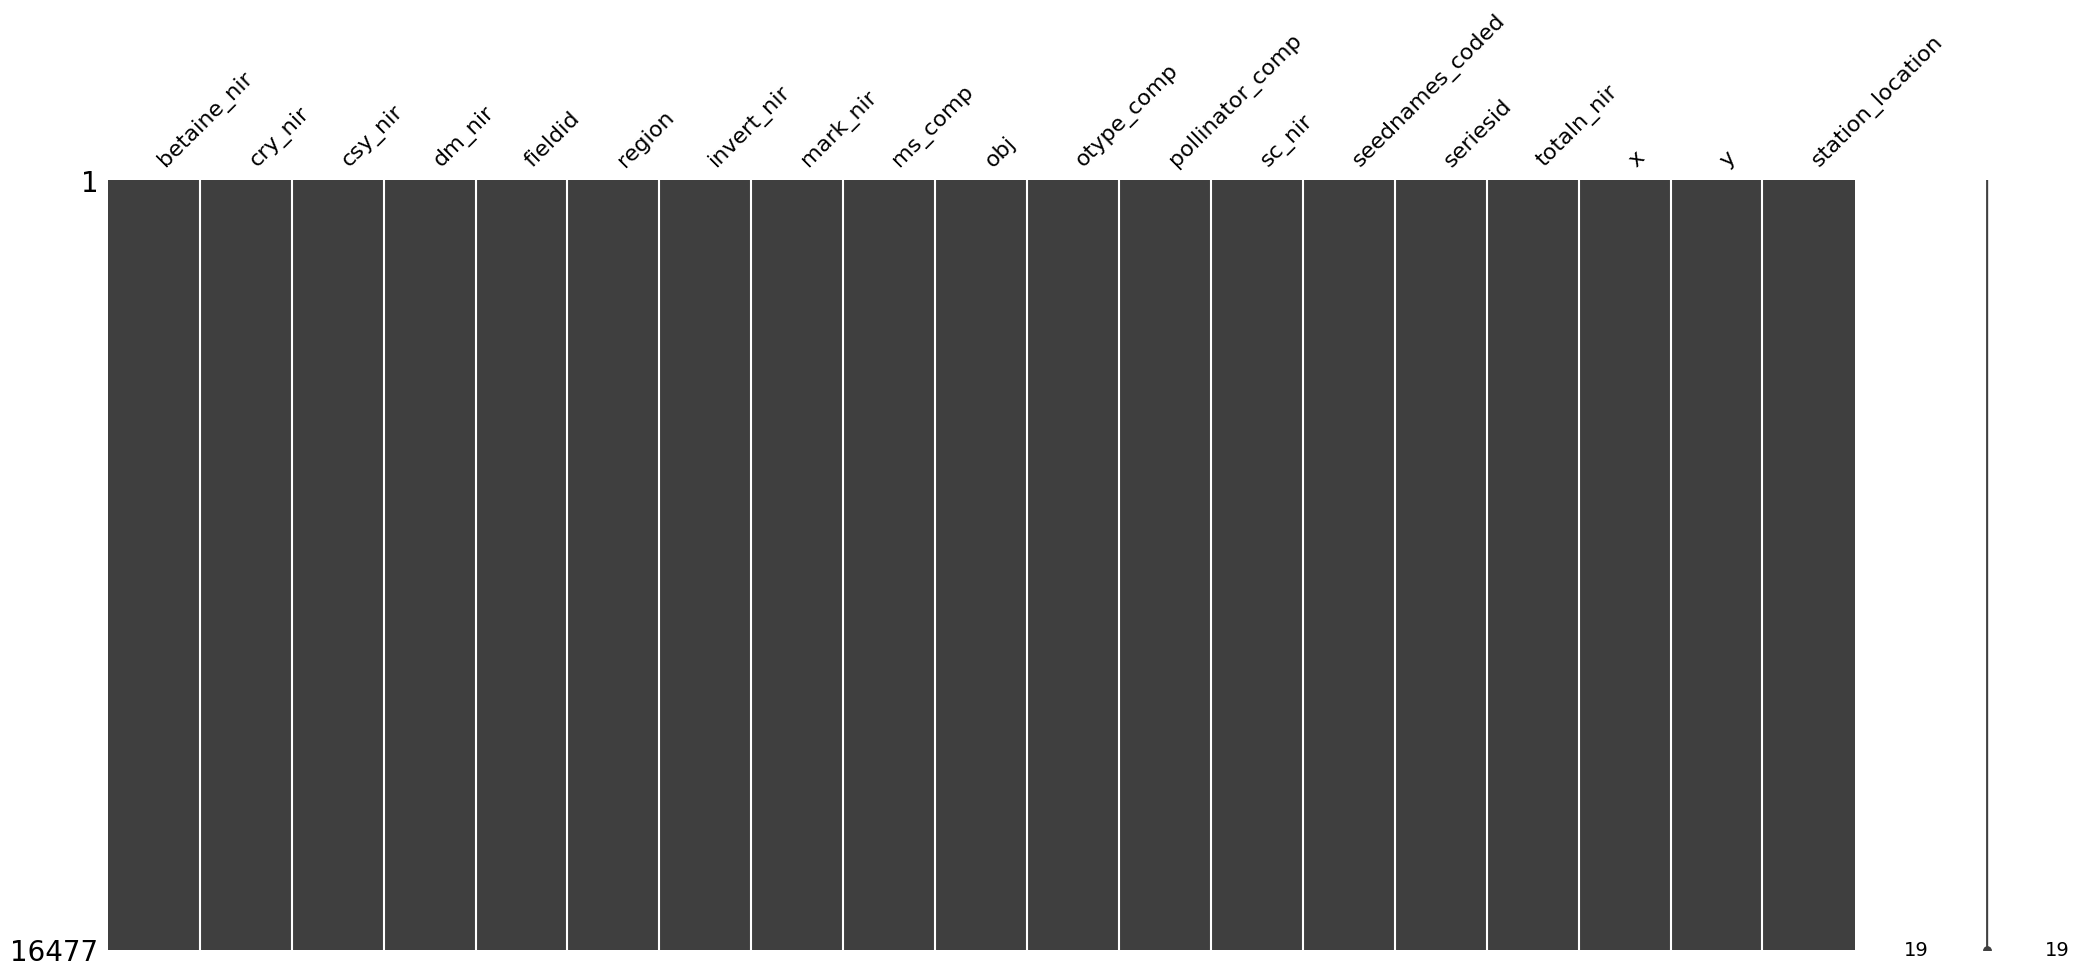

In [17]:
msno.matrix(df_sugarbeet)

<AxesSubplot:>

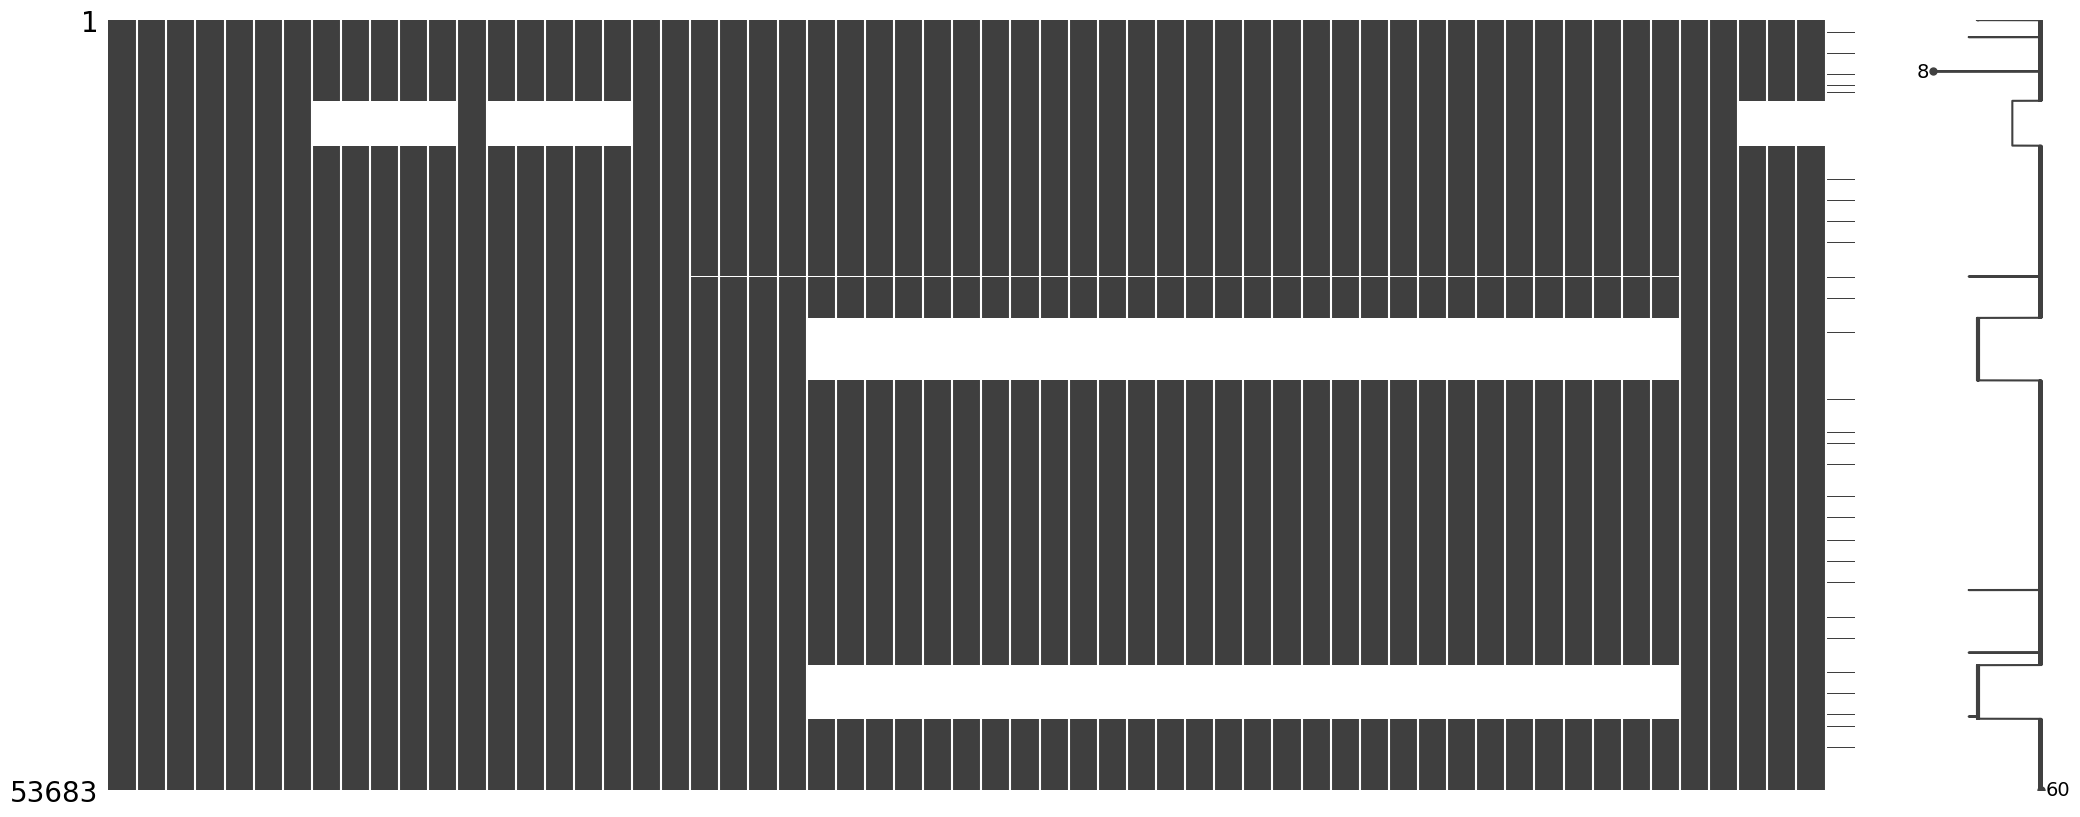

In [18]:
msno.matrix(df_weatherstations)

<AxesSubplot:>

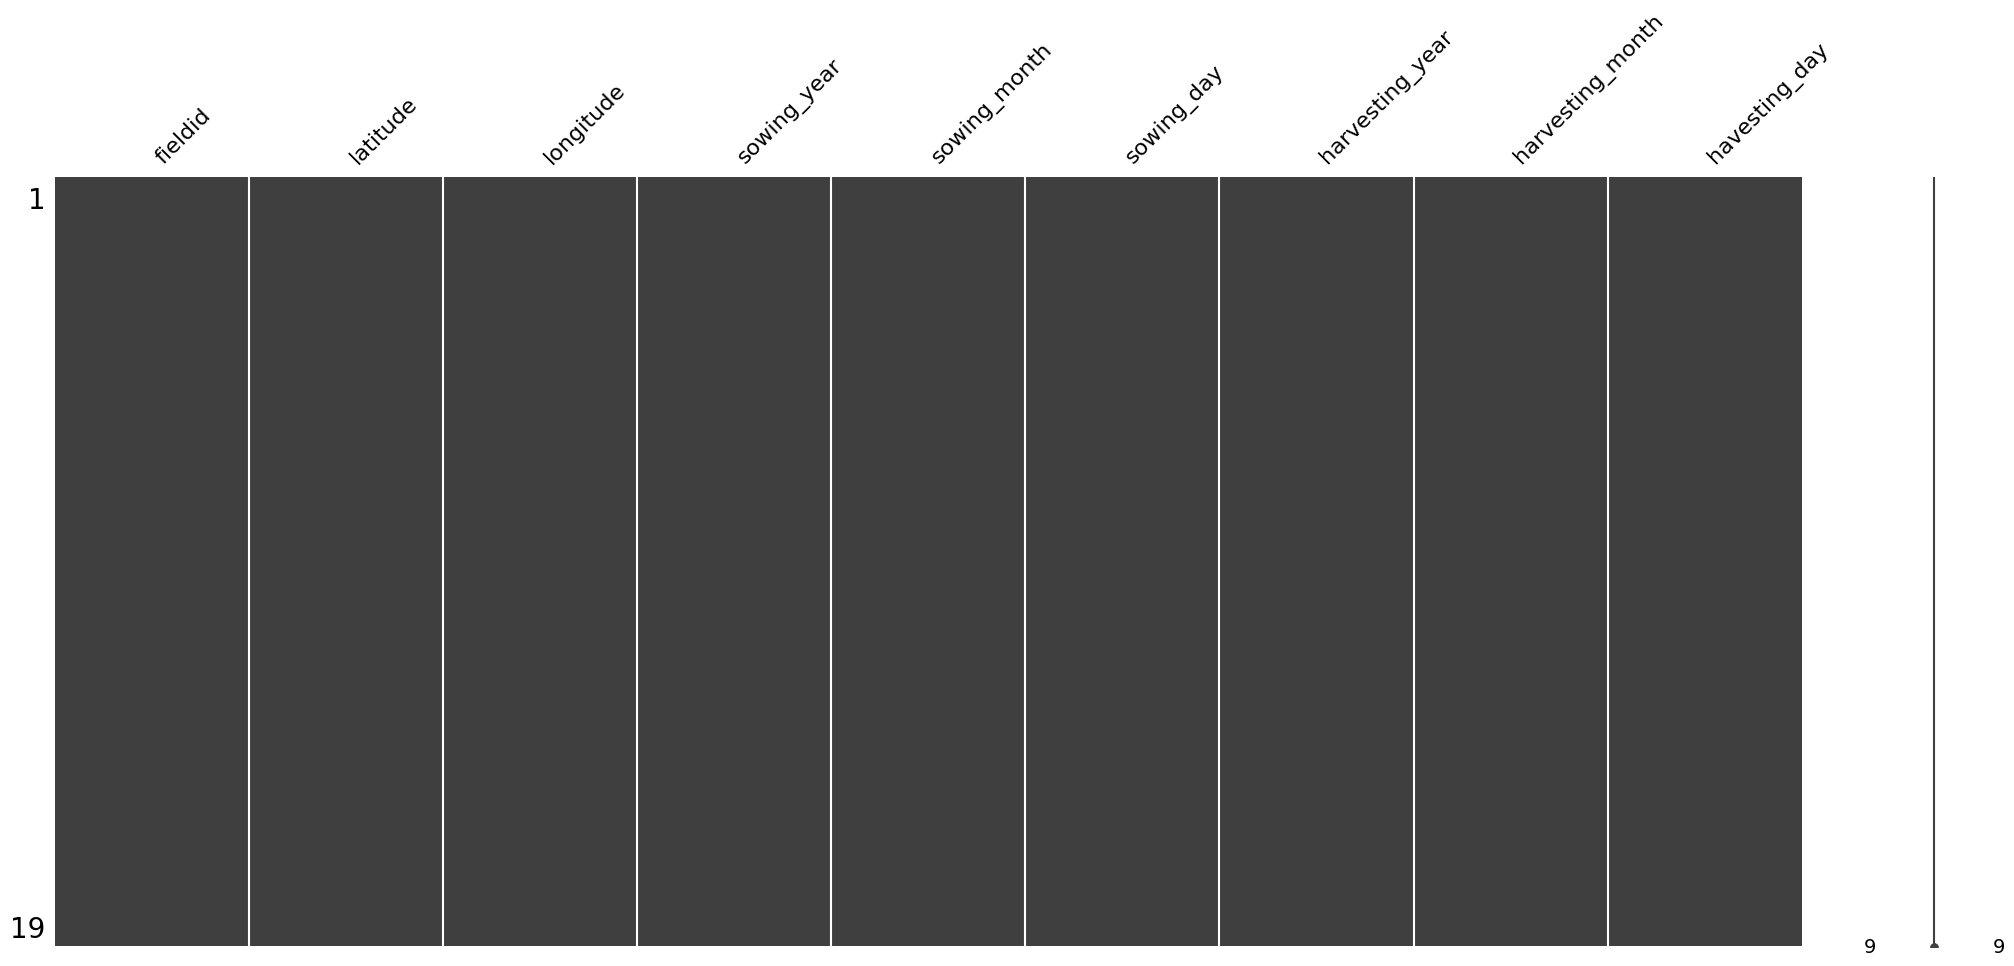

In [19]:
msno.matrix(df_locations)

<AxesSubplot:>

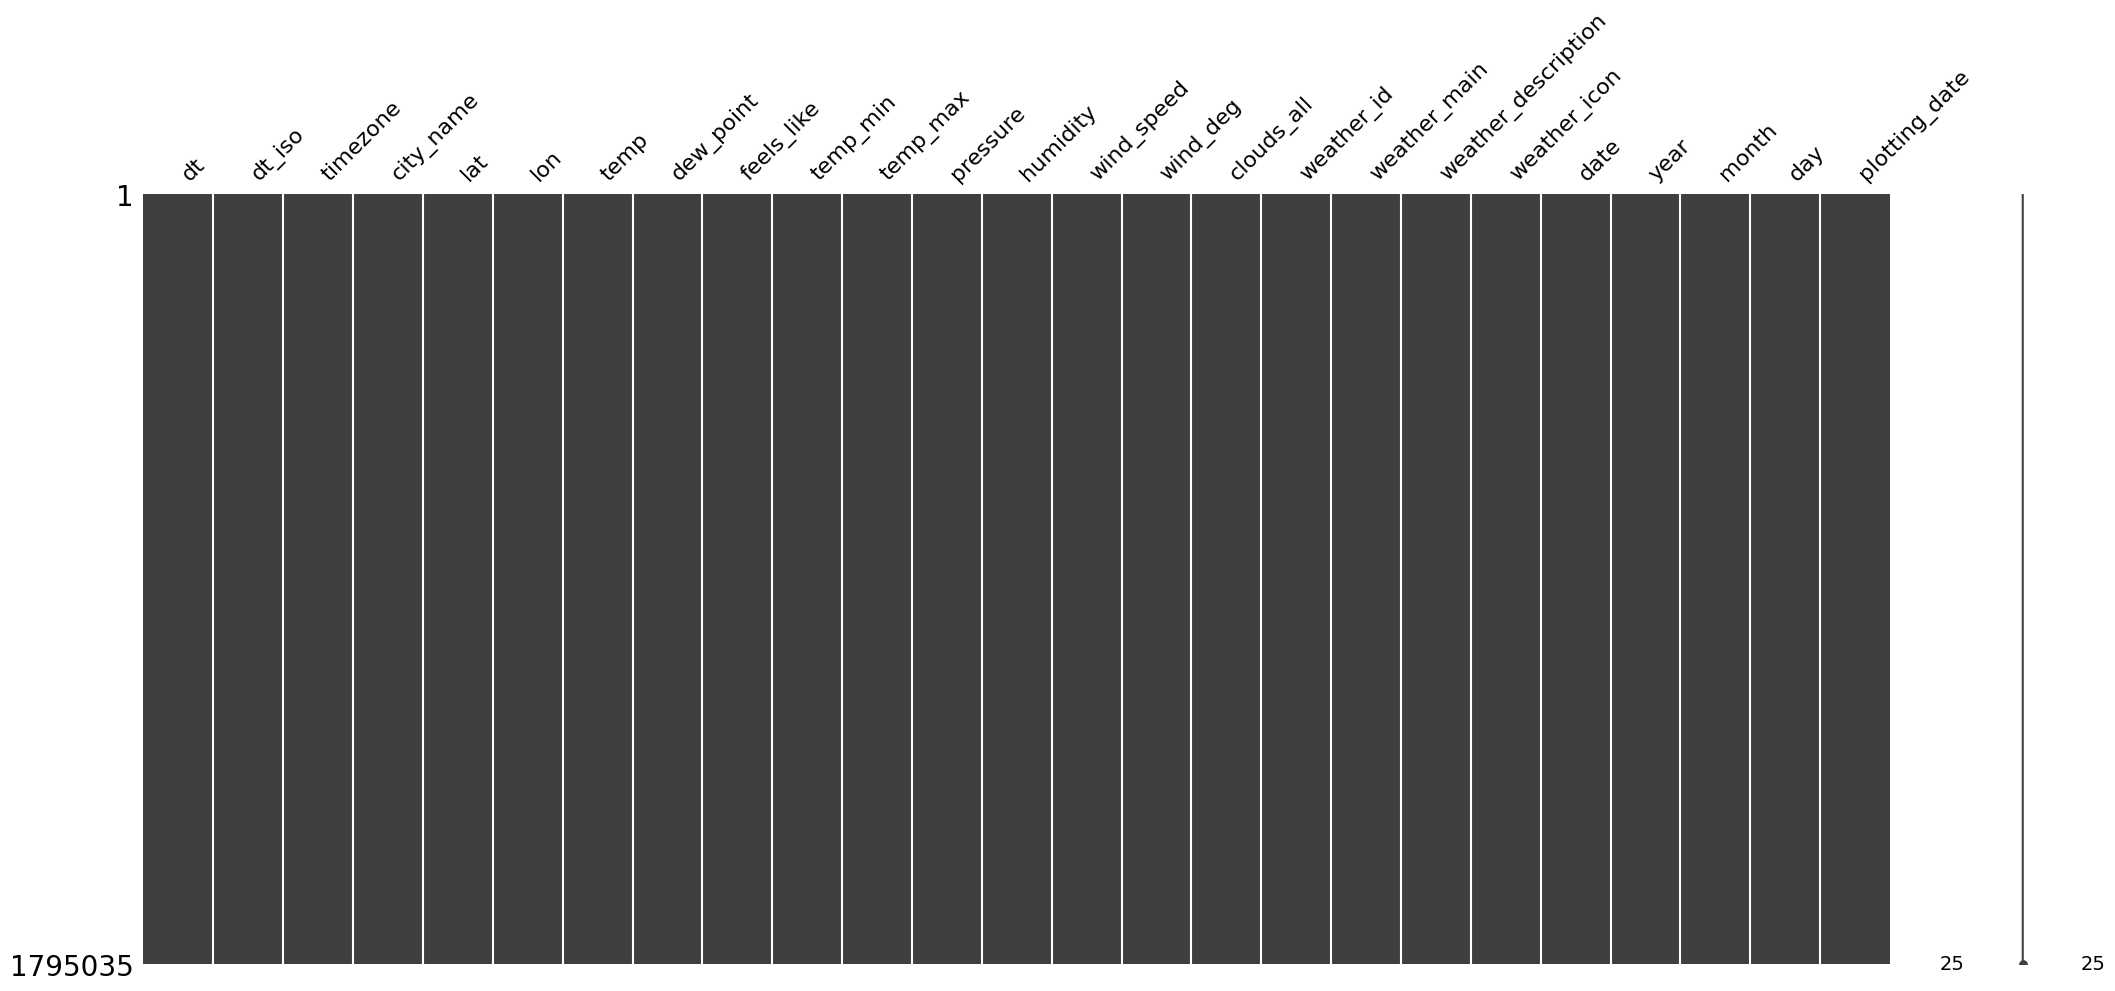

In [20]:
msno.matrix(df)

#### Visualization

##### Field Weather Stations

<AxesSubplot:xlabel='month', ylabel='soil_temperature_1_vg'>

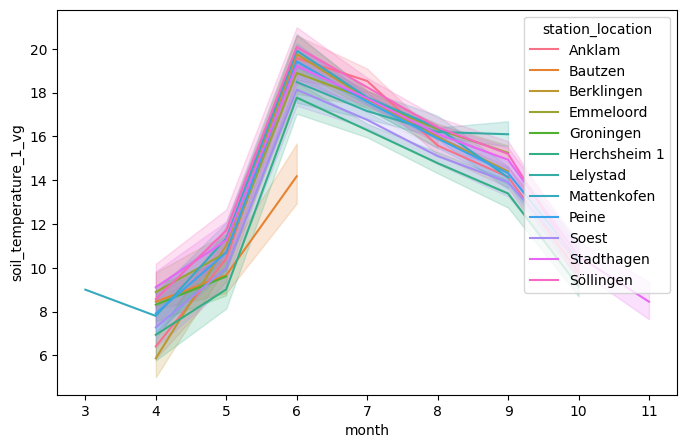

In [21]:
# plot timeline of soil temperature at 30cm depth per location
sns.lineplot(data=df_weatherstations.groupby(['station_location']).value_counts(), x='month', y='soil_temperature_1_vg', hue='station_location')

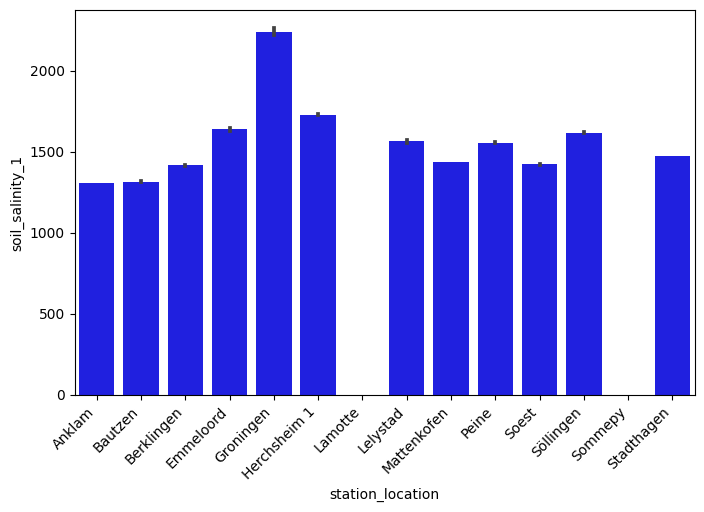

In [22]:
# plot amount of soil salinity at 30cm depth per location
fig = sns.barplot(data=df_weatherstations, x='station_location', y='soil_salinity_1', color='blue')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right');

In [23]:
df_weatherstations = df_weatherstations.assign(date = lambda x: x['date_time'].dt.date)
# Aggregate temperature by day
daily_data_df = df_weatherstations \
    .groupby(['date', 'year', 'month', 'day'], as_index=False)\
    .agg({'air_temperature_avg': np.mean}) \
    .set_index('date')

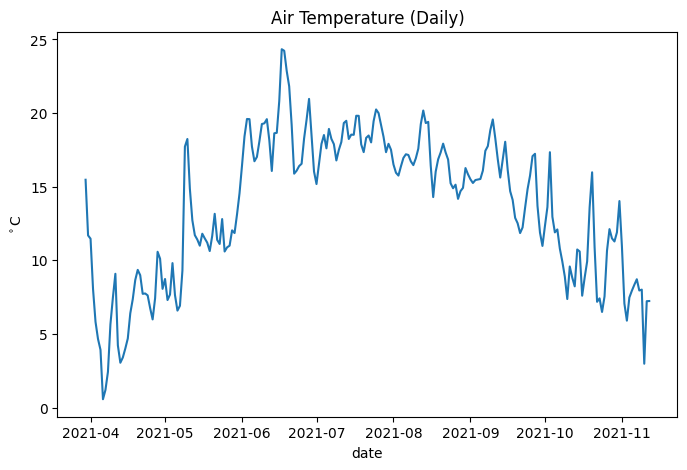

In [24]:
# Plot temperature on daily basis 
fig, ax = plt.subplots()
sns.lineplot(x='date', y='air_temperature_avg', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Air Temperature (Daily)', ylabel=r'$^\circ$C');

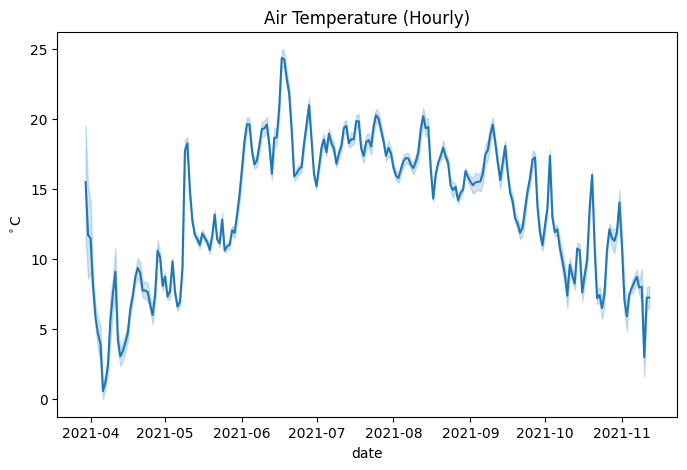

In [25]:
# Temperature hourly development over time 
fig, ax = plt.subplots()
sns.lineplot(x='date', y='air_temperature_avg', data=df_weatherstations, ax=ax)
ax.set(title='Air Temperature (Hourly)', ylabel=r'$^\circ$C');

##### Openweather

In [26]:
df_grouped = df_2021.groupby(['city_name', 'year', 'month', 'day']).mean()
#.agg({'lufttemperatur [°c]avg': 'mean', 'niederschlag [mm]': 'sum'})
df_grouped

dt  timezone   lat   lon  temp  \
city_name  year month day                                             
Anklam     2021 1     1   1609500600.00   3600.00 53.94 13.60  1.59   
                      2   1609587000.00   3600.00 53.94 13.60  2.20   
                      3   1609673400.00   3600.00 53.94 13.60  1.98   
                      4   1609759800.00   3600.00 53.94 13.60  2.39   
                      5   1609846200.00   3600.00 53.94 13.60  3.35   
...                                 ...       ...   ...   ...   ...   
VierhÃ¶fen 2021 12    27  1640604600.00   3600.00 48.75 12.71  0.23   
                      28  1640691000.00   3600.00 48.75 12.71  1.23   
                      29  1640777400.00   3600.00 48.75 12.71  6.29   
                      30  1640863800.00   3600.00 48.75 12.71  8.56   
                      31  1640950200.00   3600.00 48.75 12.71 10.11   

                           dew_point  feels_like  temp_min  temp_max  \
city_name  year month day                                              
Anklam     2021 1     1         0.86       -1.11      1.19      1.82   
                      2         1.80        0.51      1.77      2.55   
                      3         1.04       -2.14      1.55      2.59   
                      4         1.83       -1.73      1.62      3.15   
                      5         2.24       -0.29      2.95      3.83   
...                              ...         ...       ...       ...   
VierhÃ¶fen 2021 12    27       -0.45       -2.68     -0.40      2.40   
                      28        0.69       -2.30      0.77      4.38   
                      29        5.66        2.97      5.01      7.99   
                      30        8.21        6.68      7.51     12.29   
                      31        9.23        8.66      8.71     11.87   

                           pressure  humidity  wind_speed  wind_deg  \
city_name  year month day                                             
Anklam     2021 1     1     1007.04     94.92        2.48    194.04   
                      2     1014.08     97.21        1.85    185.38   
                      3     1018.42     93.50        4.83     59.21   
                      4     1019.25     96.08        4.69     64.21   
                      5     1018.21     92.50        4.24     43.62   
...                             ...       ...         ...       ...   
VierhÃ¶fen 2021 12    27    1008.00     94.88        2.52    122.62   
                      28    1004.29     96.08        3.56    178.17   
                      29    1009.67     95.79        5.18    257.88   
                      30    1019.46     97.67        4.93    261.21   
                      31    1023.75     94.29        3.69    247.25   

                           clouds_all  weather_id  plotting_date  
city_name  year month day                                         
Anklam     2021 1     1         97.29      791.33           1.00  
                      2         99.21      698.00           2.00  
                      3         94.46      656.04           3.00  
                      4         99.75      529.17           4.00  
                      5         98.46      740.67           5.00  
...                               ...         ...            ...  
VierhÃ¶fen 2021 12    27        83.25      761.17         361.00  
                      28        98.33      618.00         362.00  
                      29        97.46      563.46         363.00  
                      30        97.58      664.79         364.00  
                      31        26.46      801.21         365.00  

[5840 rows x 16 columns]

<AxesSubplot:xlabel='plotting_date', ylabel='temp'>

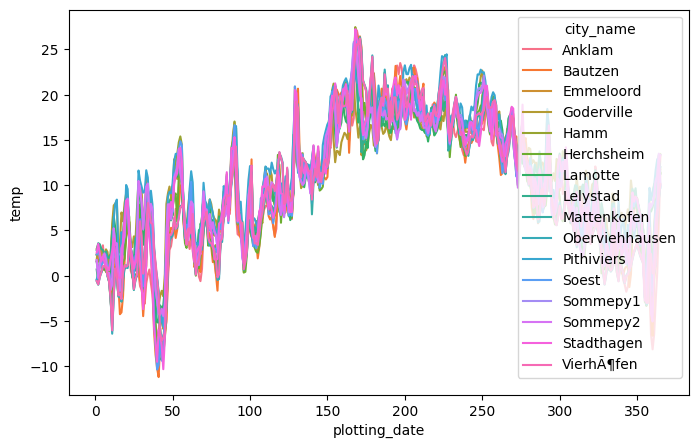

In [27]:
sns.lineplot(data=df_grouped, x = 'plotting_date', y = 'temp', hue = 'city_name')
#plt.savefig('figures/Lufttemperatur.png') # , dpi= 300) # for high resolution

<AxesSubplot:xlabel='plotting_date', ylabel='dew_point'>

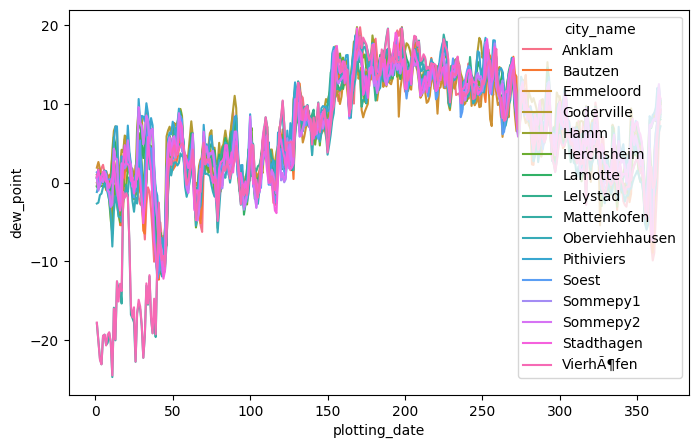

In [28]:
sns.lineplot(data=df_grouped, x = 'plotting_date', y = 'dew_point', hue = 'city_name')

<AxesSubplot:xlabel='plotting_date', ylabel='pressure'>

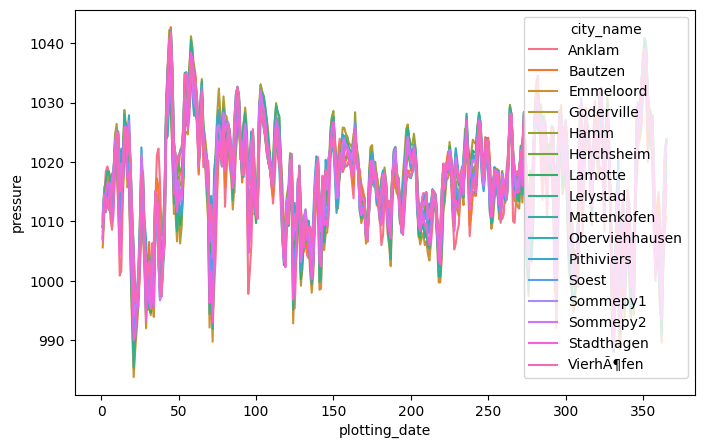

In [29]:
sns.lineplot(data=df_grouped, x = 'plotting_date', y = 'pressure', hue = 'city_name')

<AxesSubplot:xlabel='plotting_date', ylabel='humidity'>

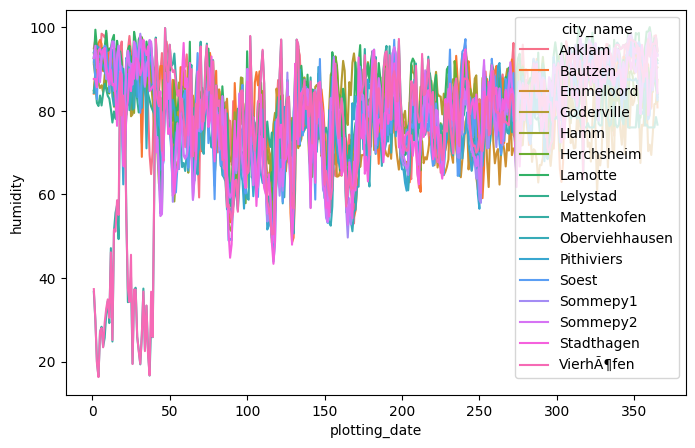

In [30]:
sns.lineplot(data=df_grouped, x = 'plotting_date', y = 'humidity', hue = 'city_name')

<AxesSubplot:xlabel='plotting_date', ylabel='wind_speed'>

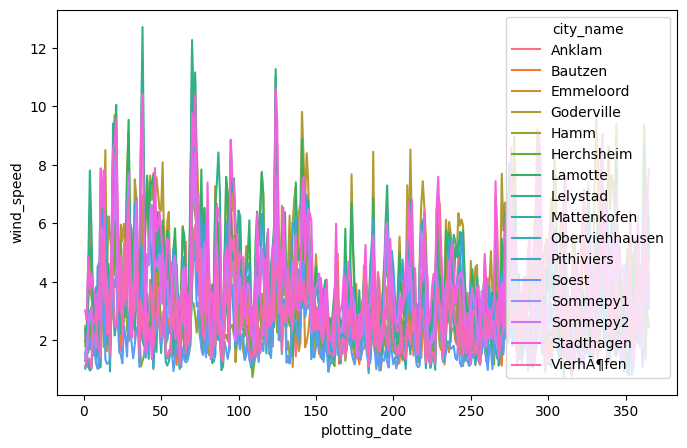

In [31]:
sns.lineplot(data=df_grouped, x = 'plotting_date', y = 'wind_speed', hue = 'city_name')

#### Sugarbeet Data

<AxesSubplot:xlabel='csy_nir', ylabel='ms_comp'>

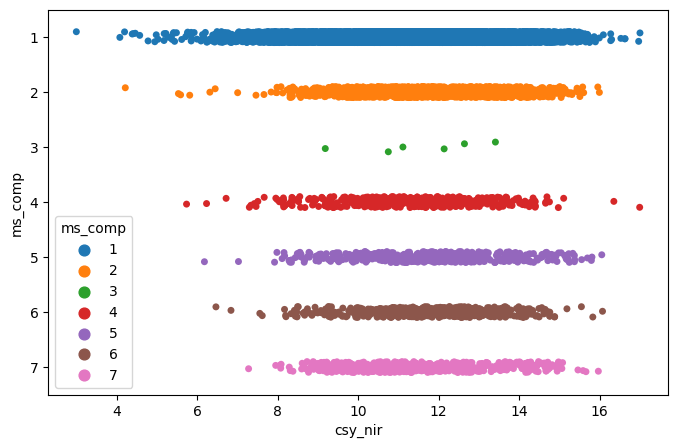

In [32]:
sns.stripplot(y='ms_comp', x='csy_nir', hue='ms_comp', orient='h', data=df_sugarbeet)

<AxesSubplot:xlabel='csy_nir', ylabel='otype_comp'>

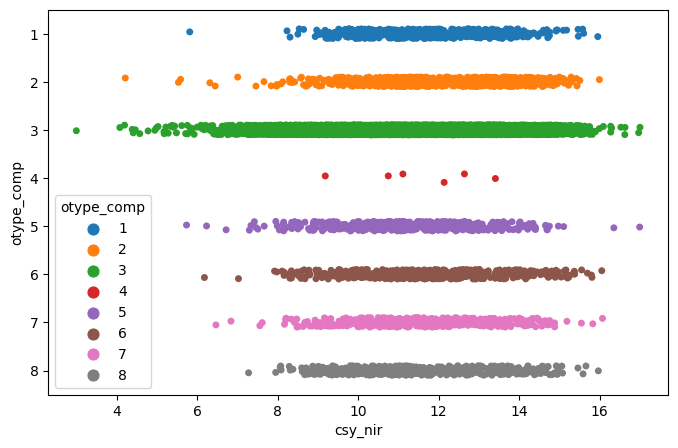

In [33]:
sns.stripplot(y='otype_comp', x='csy_nir', hue='otype_comp', orient='h', data=df_sugarbeet)

##### Field Location

In [34]:
# use plotly mapbox to map the houses within her price range & preferred area

fig = px.scatter_mapbox(df_locations, lat='latitude', lon='longitude', color='fieldid', title='Fieldlocations', color_continuous_scale=px.colors.sequential.Bluered, hover_name='fieldid')
fig.update_layout( mapbox_style='open-street-map', title_x=0.5, legend_title_text='fieldid')
#fig.update_mapboxes(zoom=10.5, center_lat=47.6062, center_lon=-122.3321)
fig.show()
